In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PIL import Image

import cv2

In [3]:
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from keras.activations import softmax
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             accuracy_score)

In [35]:
def data_dictionary():
    path_train = "archive/train3/"
    path_test = "archive/test3/"
    list_train = os.listdir(path_train)
    train_dictionary = {"image_path":[], "target":[]}
    test_dictionary = {"image_path":[], "target":[]}
    k = 0
    for i in list_train:
        path_disease_train = path_train+i
        path_disease_test = path_test+i
        image_list_train = os.listdir(path_disease_train)
        image_list_test = os.listdir(path_disease_test)
        for j in image_list_train:
            img_path_train = path_disease_train+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k) 
        for m in image_list_test :
            img_path_test = path_disease_test + "/" + m
            test_dictionary["image_path"].append(img_path_test)
            test_dictionary['target'].append(k)
        k += 1 
    test_df = pd.DataFrame(test_dictionary)
    train_df = pd.DataFrame(train_dictionary)
        
    return  train_df, test_df

In [20]:
def load_data(input_size = (100, 100)):
    images = []
    images2 = []
    train_df, test_df = data_dictionary()
    for i in train_df['image_path']:
        img = cv2.imread(i)
        img = cv2.resize(img, input_size)
        images.append(img)
    y_train = np.asarray(train_df['target'])
    x_train = np.asarray(images)
    for i in test_df['image_path']:
        img = cv2.imread(i)
        img = cv2.resize(img, input_size)
        images2.append(img)
    y_test = np.asarray(test_df['target'])
    x_test = np.asarray(images2)
    return x_train, x_test, y_train, y_test

In [36]:
x_train, x_test, y_train, y_test = load_data(input_size = (100,100))

In [25]:
from keras.applications import  VGG19
from keras.models import Model
from keras.applications.vgg19 import preprocess_input

In [37]:
vgg19 = VGG19(include_top = False, weights = 'imagenet')

In [11]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [38]:
vgg19.trainable = True
trainable = False
for layer in vgg19.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

    

In [39]:
import joblib

filename = "vgg19.sav"
joblib.dump(vgg19, open(filename, 'wb'))



vgg19 = joblib.load("vgg19.sav")



train_img = preprocess_input(x_train)
test_img = preprocess_input(x_test)



features_train = vgg19.predict(train_img)

features_test = vgg19.predict(test_img)

features_train.shape

features_test.shape



num_train = x_train.shape[0]
num_test = x_test.shape[0]

x_train = features_train.reshape(num_train, 4608)
x_test = features_test.reshape(num_test, 4608)

126/126 [==============================] - 139s 1s/step


In [40]:
x_train = features_train.reshape(num_train, 4608)
x_test = features_test.reshape(num_test, 4608)

In [30]:
from keras.models import Sequential
from keras.layers import Dense

In [58]:
model = Sequential([Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(23,activation=tf.keras.activations.softmax),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
263/263 [==============================] - 28s 96ms/step - loss: 5.3598 - accuracy: 0.0977 - val_loss: 3.5940 - val_accuracy: 0.1412
Epoch 2/10
263/263 [==============================] - 25s 96ms/step - loss: 3.1957 - accuracy: 0.1744 - val_loss: 3.0765 - val_accuracy: 0.1884
Epoch 3/10
263/263 [==============================] - 24s 93ms/step - loss: 2.7456 - accuracy: 0.2397 - val_loss: 2.8556 - val_accuracy: 0.2354
Epoch 4/10
263/263 [==============================] - 25s 96ms/step - loss: 2.4459 - accuracy: 0.3055 - val_loss: 2.7128 - val_accuracy: 0.2649
Epoch 5/10
263/263 [==============================] - 26s 97ms/step - loss: 2.2049 - accuracy: 0.3688 - val_loss: 2.5918 - val_accuracy: 0.2961
Epoch 6/10
263/263 [==============================] - 25s 93ms/step - loss: 1.9972 - accuracy: 0.4288 - val_loss: 2.5004 - val_accuracy: 0.3241
Epoch 7/10
263/263 [==============================] - 26s 99ms/step - loss: 1.8122 - accuracy: 0.4869 - val_loss: 2.4178 - val_accuracy:

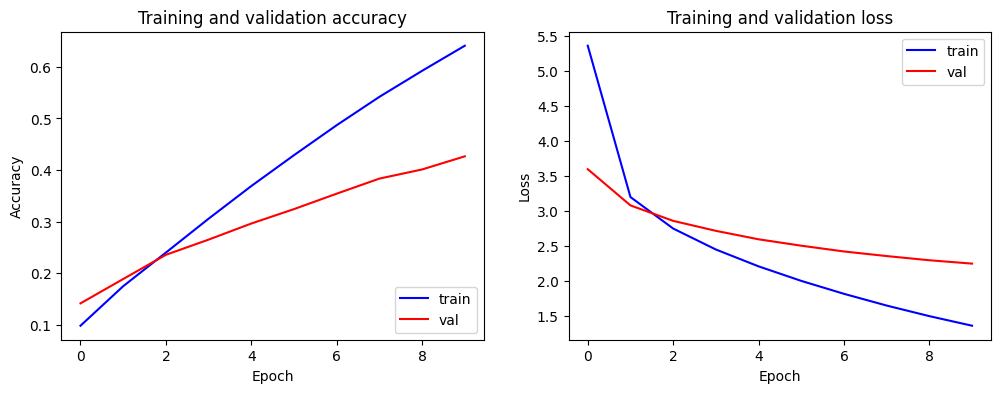

In [59]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [66]:
model = Sequential([Dense(2048,activation='relu'),
                    Dense(1024,activation='relu'),
                    Dense(768,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(23,activation=tf.keras.activations.softmax),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
263/263 [==============================] - 65s 242ms/step - loss: 3.1830 - accuracy: 0.1428 - val_loss: 2.7524 - val_accuracy: 0.2171
Epoch 2/10
263/263 [==============================] - 62s 236ms/step - loss: 2.5285 - accuracy: 0.2599 - val_loss: 2.5210 - val_accuracy: 0.2859
Epoch 3/10
263/263 [==============================] - 62s 234ms/step - loss: 2.1805 - accuracy: 0.3660 - val_loss: 2.3565 - val_accuracy: 0.3313
Epoch 4/10
263/263 [==============================] - 61s 234ms/step - loss: 1.8778 - accuracy: 0.4674 - val_loss: 2.2242 - val_accuracy: 0.3828
Epoch 5/10
263/263 [==============================] - 63s 239ms/step - loss: 1.6035 - accuracy: 0.5637 - val_loss: 2.1151 - val_accuracy: 0.4265
Epoch 6/10
263/263 [==============================] - 62s 235ms/step - loss: 1.3585 - accuracy: 0.6490 - val_loss: 2.0293 - val_accuracy: 0.4560
Epoch 7/10
263/263 [==============================] - 63s 238ms/step - loss: 1.1466 - accuracy: 0.7178 - val_loss: 1.9602 - val_ac

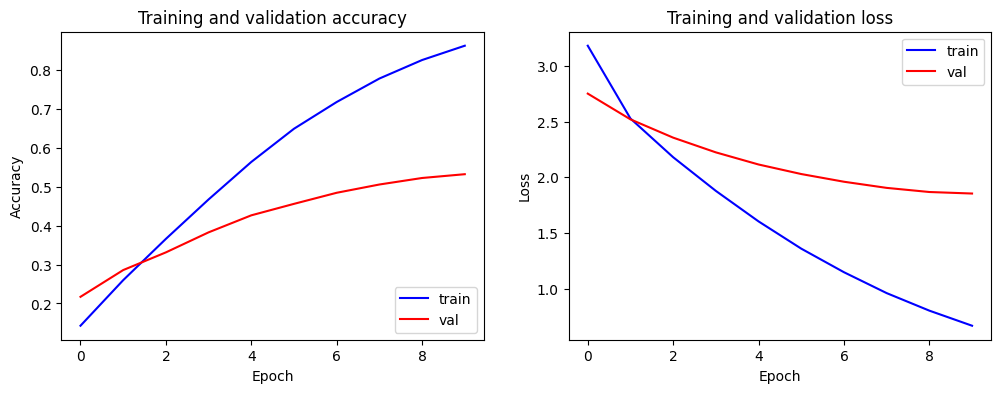

In [67]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [68]:
model = Sequential([Dense(2048,activation='relu'),
                    Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(23,activation=tf.keras.activations.softmax),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
263/263 [==============================] - 57s 210ms/step - loss: 5.6983 - accuracy: 0.0514 - val_loss: 4.5580 - val_accuracy: 0.0650
Epoch 2/10
263/263 [==============================] - 55s 209ms/step - loss: 4.0797 - accuracy: 0.0836 - val_loss: 3.7998 - val_accuracy: 0.0950
Epoch 3/10
263/263 [==============================] - 55s 211ms/step - loss: 3.5696 - accuracy: 0.1128 - val_loss: 3.4930 - val_accuracy: 0.1194
Epoch 4/10
263/263 [==============================] - 57s 217ms/step - loss: 3.3123 - accuracy: 0.1340 - val_loss: 3.3214 - val_accuracy: 0.1337
Epoch 5/10
263/263 [==============================] - 61s 232ms/step - loss: 3.1461 - accuracy: 0.1551 - val_loss: 3.2036 - val_accuracy: 0.1524
Epoch 6/10
263/263 [==============================] - 59s 223ms/step - loss: 3.0208 - accuracy: 0.1740 - val_loss: 3.1185 - val_accuracy: 0.1622
Epoch 7/10
263/263 [==============================] - 60s 230ms/step - loss: 2.9170 - accuracy: 0.1896 - val_loss: 3.0477 - val_ac

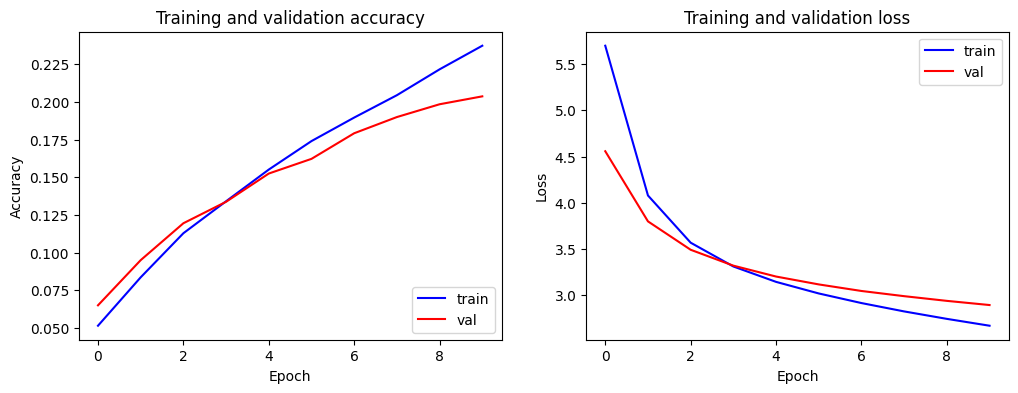

In [69]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [70]:
model = Sequential([Dense(2048,activation='relu'),
                    Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(23,activation=tf.keras.activations.softmax),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 10, validation_data = (x_test, y_test))

Epoch 1/10
263/263 [==============================] - 56s 208ms/step - loss: 2.8041 - accuracy: 0.2210 - val_loss: 2.3068 - val_accuracy: 0.3353
Epoch 2/10
263/263 [==============================] - 55s 209ms/step - loss: 1.8791 - accuracy: 0.4475 - val_loss: 2.0040 - val_accuracy: 0.4458
Epoch 3/10
263/263 [==============================] - 55s 209ms/step - loss: 1.1801 - accuracy: 0.6638 - val_loss: 1.7981 - val_accuracy: 0.5235
Epoch 4/10
263/263 [==============================] - 61s 230ms/step - loss: 0.6735 - accuracy: 0.8202 - val_loss: 1.8278 - val_accuracy: 0.5602
Epoch 5/10
263/263 [==============================] - 58s 222ms/step - loss: 0.4054 - accuracy: 0.9055 - val_loss: 1.8055 - val_accuracy: 0.5867
Epoch 6/10
263/263 [==============================] - 55s 210ms/step - loss: 0.2859 - accuracy: 0.9393 - val_loss: 1.8591 - val_accuracy: 0.5960
Epoch 7/10
263/263 [==============================] - 56s 212ms/step - loss: 0.2277 - accuracy: 0.9520 - val_loss: 1.8372 - val_ac

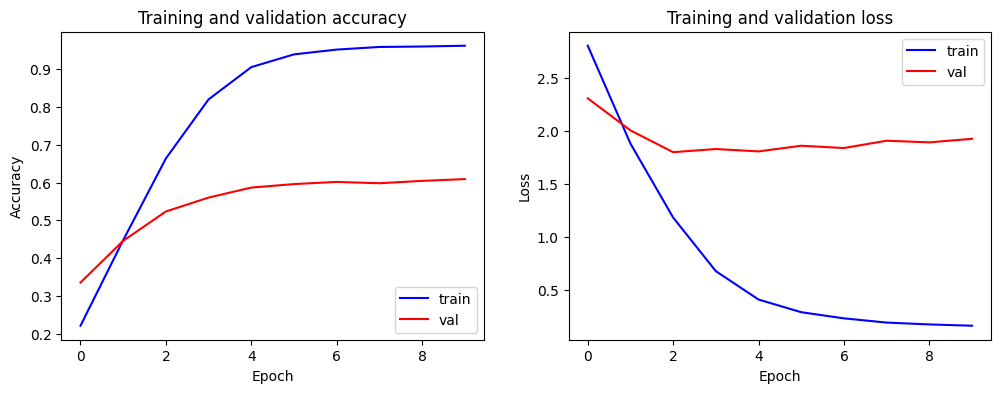

In [71]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

Финал модель

In [72]:
model = Sequential([Dense(2048,activation='relu'),
                    Dense(1024,activation='relu'),
                    Dense(512,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(23,activation=tf.keras.activations.softmax),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size = 64, epochs = 50, validation_data = (x_test, y_test))

Epoch 1/50
263/263 [==============================] - 55s 205ms/step - loss: 3.6196 - accuracy: 0.1330 - val_loss: 2.9039 - val_accuracy: 0.1919
Epoch 2/50
263/263 [==============================] - 53s 202ms/step - loss: 2.6111 - accuracy: 0.2558 - val_loss: 2.5963 - val_accuracy: 0.2751
Epoch 3/50
263/263 [==============================] - 53s 203ms/step - loss: 2.1743 - accuracy: 0.3700 - val_loss: 2.4089 - val_accuracy: 0.3398
Epoch 4/50
263/263 [==============================] - 54s 205ms/step - loss: 1.8296 - accuracy: 0.4816 - val_loss: 2.2722 - val_accuracy: 0.3868
Epoch 5/50
263/263 [==============================] - 58s 222ms/step - loss: 1.5444 - accuracy: 0.5757 - val_loss: 2.1685 - val_accuracy: 0.4285
Epoch 6/50
263/263 [==============================] - 56s 212ms/step - loss: 1.3030 - accuracy: 0.6600 - val_loss: 2.0886 - val_accuracy: 0.4608
Epoch 7/50
263/263 [==============================] - 55s 209ms/step - loss: 1.1017 - accuracy: 0.7282 - val_loss: 2.0251 - val_ac

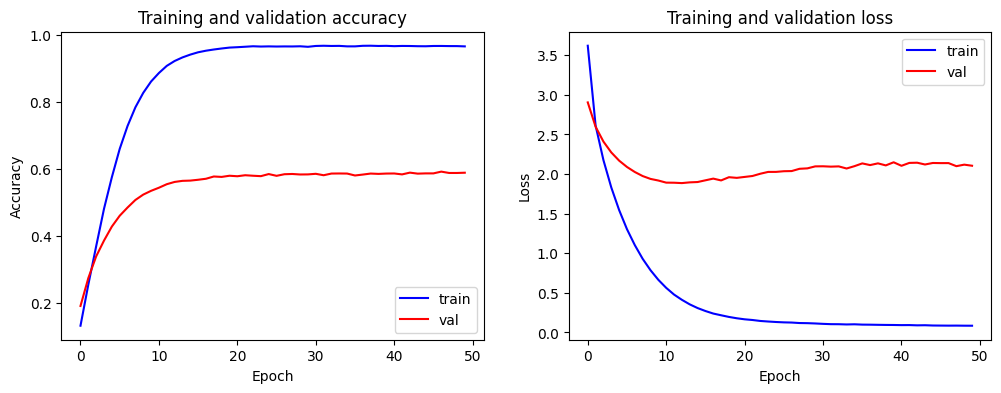

In [73]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

In [75]:
model.evaluate(x_test,y_test)

126/126 [==============================] - 2s 17ms/step - loss: 2.1042 - accuracy: 0.5890


[2.1042404174804688, 0.5889555215835571]

In [137]:
def load_img(img_path):
    images=[]
    img=cv2.imread(str(img_path))
    img=cv2.resize(img,(100,100))
    images.append(img)
    x_test=np.asarray(images)
    test_img=preprocess_input(x_test)
    features_test=vgg16.predict(test_img)
    num_test=x_test.shape[0]
    f_img=features_test.reshape(num_test,4608)


    return f_img

In [88]:
img = load_img('D:/univ/diplom/diplom/archive/test/Psoriasis pictures Lichen Planus and related diseases/08lichenPlanusTongue1122052.jpg')


path_train = "D:/univ/diplom/diplom/archive/train/"
list_train = os.listdir(path_train)

print(tf.nn.softmax(model(img)) * 100)

print(model.predict(img)[0])

print(round(100 * (np.max(model.predict(img)[0])), 2))

1/1 [==============================] - 0s 168ms/step
[[5.37906773e-04 1.24324067e-03 6.42984403e-08 1.28023412e-05
  1.68016836e-08 2.21783594e-07 6.81776146e-05 1.20913754e-07
  3.98141901e-06 1.64336871e-05 3.10256632e-06 1.50099922e-05
  1.16005329e-04 1.38149945e-08 9.96232450e-01 5.34622406e-04
  2.07813696e-06 6.89168955e-05 7.41441327e-05 1.11188474e-05
  9.22481777e-05 1.15856892e-07 9.67176806e-04]]
tf.Tensor(
[0.04048822 0.04051679 0.04046645 0.04046697 0.04046645 0.04046646
 0.04046921 0.04046645 0.04046661 0.04046712 0.04046657 0.04046706
 0.04047114 0.04046645 0.10958557 0.04048809 0.04046654 0.04046924
 0.04046945 0.0404669  0.04047018 0.04046645 0.04050561], shape=(23,), dtype=float32)
10.958556830883026
  jgjg  Psoriasis pictures Lichen Planus and related diseases
tf.Tensor(
[[ 4.0488224  4.051679   4.046645   4.0466967  4.046645   4.046646
   4.0469213  4.046645   4.0466614  4.046712   4.046657   4.0467057
   4.0471144  4.046645  10.958557   4.048809   4.0466537  4.046

Psoriasis pictures Lichen Planus and related diseases/08lichenPlanusTongue1122052.jpg

Acne and Rosacea Photos/07RosaceaOK0828063.jpg

In [74]:
!mkdir -p saved_model

model.save('D:/univ/diplom/diplom/res-with-percents-v4')

�������� ��� 䠩� -p 㦥 �������.
�訡�� �� �६� ��ࠡ�⪨: -p.
�������� ��� 䠩� saved_model 㦥 �������.
�訡�� �� �६� ��ࠡ�⪨: saved_model.


INFO:tensorflow:Assets written to: D:/univ/diplom/diplom/res-with-percents-v4\assets


INFO:tensorflow:Assets written to: D:/univ/diplom/diplom/res-with-percents-v4\assets


In [157]:
from os.path import isdir
import os
import glob
# path = "C:/Users/pomme/test"
# subfolders = glob.glob(path+"/*")
# for foldername in subfolders:
#     print(os.path.normcase(foldername))


def parse_folder(path):
    files = []
    paths = []
    names = []
    for file in os.listdir(path):
        if isdir(path + '/' + file):
            files.extend(parse_folder(path + '/' + file))
        else:
            files.append(path + '/' + file)
            names.append(file)
    
    subfolders = glob.glob(path+"/*")
    for foldername in subfolders:
        paths.append(os.path.normcase(foldername))

    return paths, names, names

In [91]:
class_names = os.listdir(path_train)

In [122]:
def predict(model, img):
    img_array = load_img(img)
    # img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [194]:
images_path = "D:/univ/diplom/diplom/archive/control"

# plt.figure(figsize=(15, 15))

paths, images, names = parse_folder(images_path)
print(images, "\n", names)
for name in names:
    print (name[0:-4])

print(paths)


['82013733924881274dfb61ec0d78f108_800xauto-q-85.jpg', 'Actinic keratosis.jpg', 'actinicKeratosis.jpg', 'atopic dermatitis.jpg', 'contactDermatitis.jpg', 'exantema.jpg', 'exanthema.jpg', 'hives.jpg', 'HPV.jpg', 'Krapivnitsa.jpg', 'lichenPlanus.jpg', 'melanoma.jpg', 'mollusc.jpg', 'mollusk.jpg', 'nailFungus.jpg', 'pigmentationDisorders.jpg', 'psoriasis (2).jpg', 'psoriasis.jpg', 'Seborejnyj-keratoz.jpg', 'streptoderma.jpg', 'systemicDisease.jpg', 'systemicDiseaseOrLupus.jpg', 'Tinea Corporis (2).jpg', 'vascularNeoplasms.jpg', 'vasculitis.jpg'] 
 ['82013733924881274dfb61ec0d78f108_800xauto-q-85.jpg', 'Actinic keratosis.jpg', 'actinicKeratosis.jpg', 'atopic dermatitis.jpg', 'contactDermatitis.jpg', 'exantema.jpg', 'exanthema.jpg', 'hives.jpg', 'HPV.jpg', 'Krapivnitsa.jpg', 'lichenPlanus.jpg', 'melanoma.jpg', 'mollusc.jpg', 'mollusk.jpg', 'nailFungus.jpg', 'pigmentationDisorders.jpg', 'psoriasis (2).jpg', 'psoriasis.jpg', 'Seborejnyj-keratoz.jpg', 'streptoderma.jpg', 'systemicDisease.jpg',

1/1 [==============================] - 0s 30ms/step


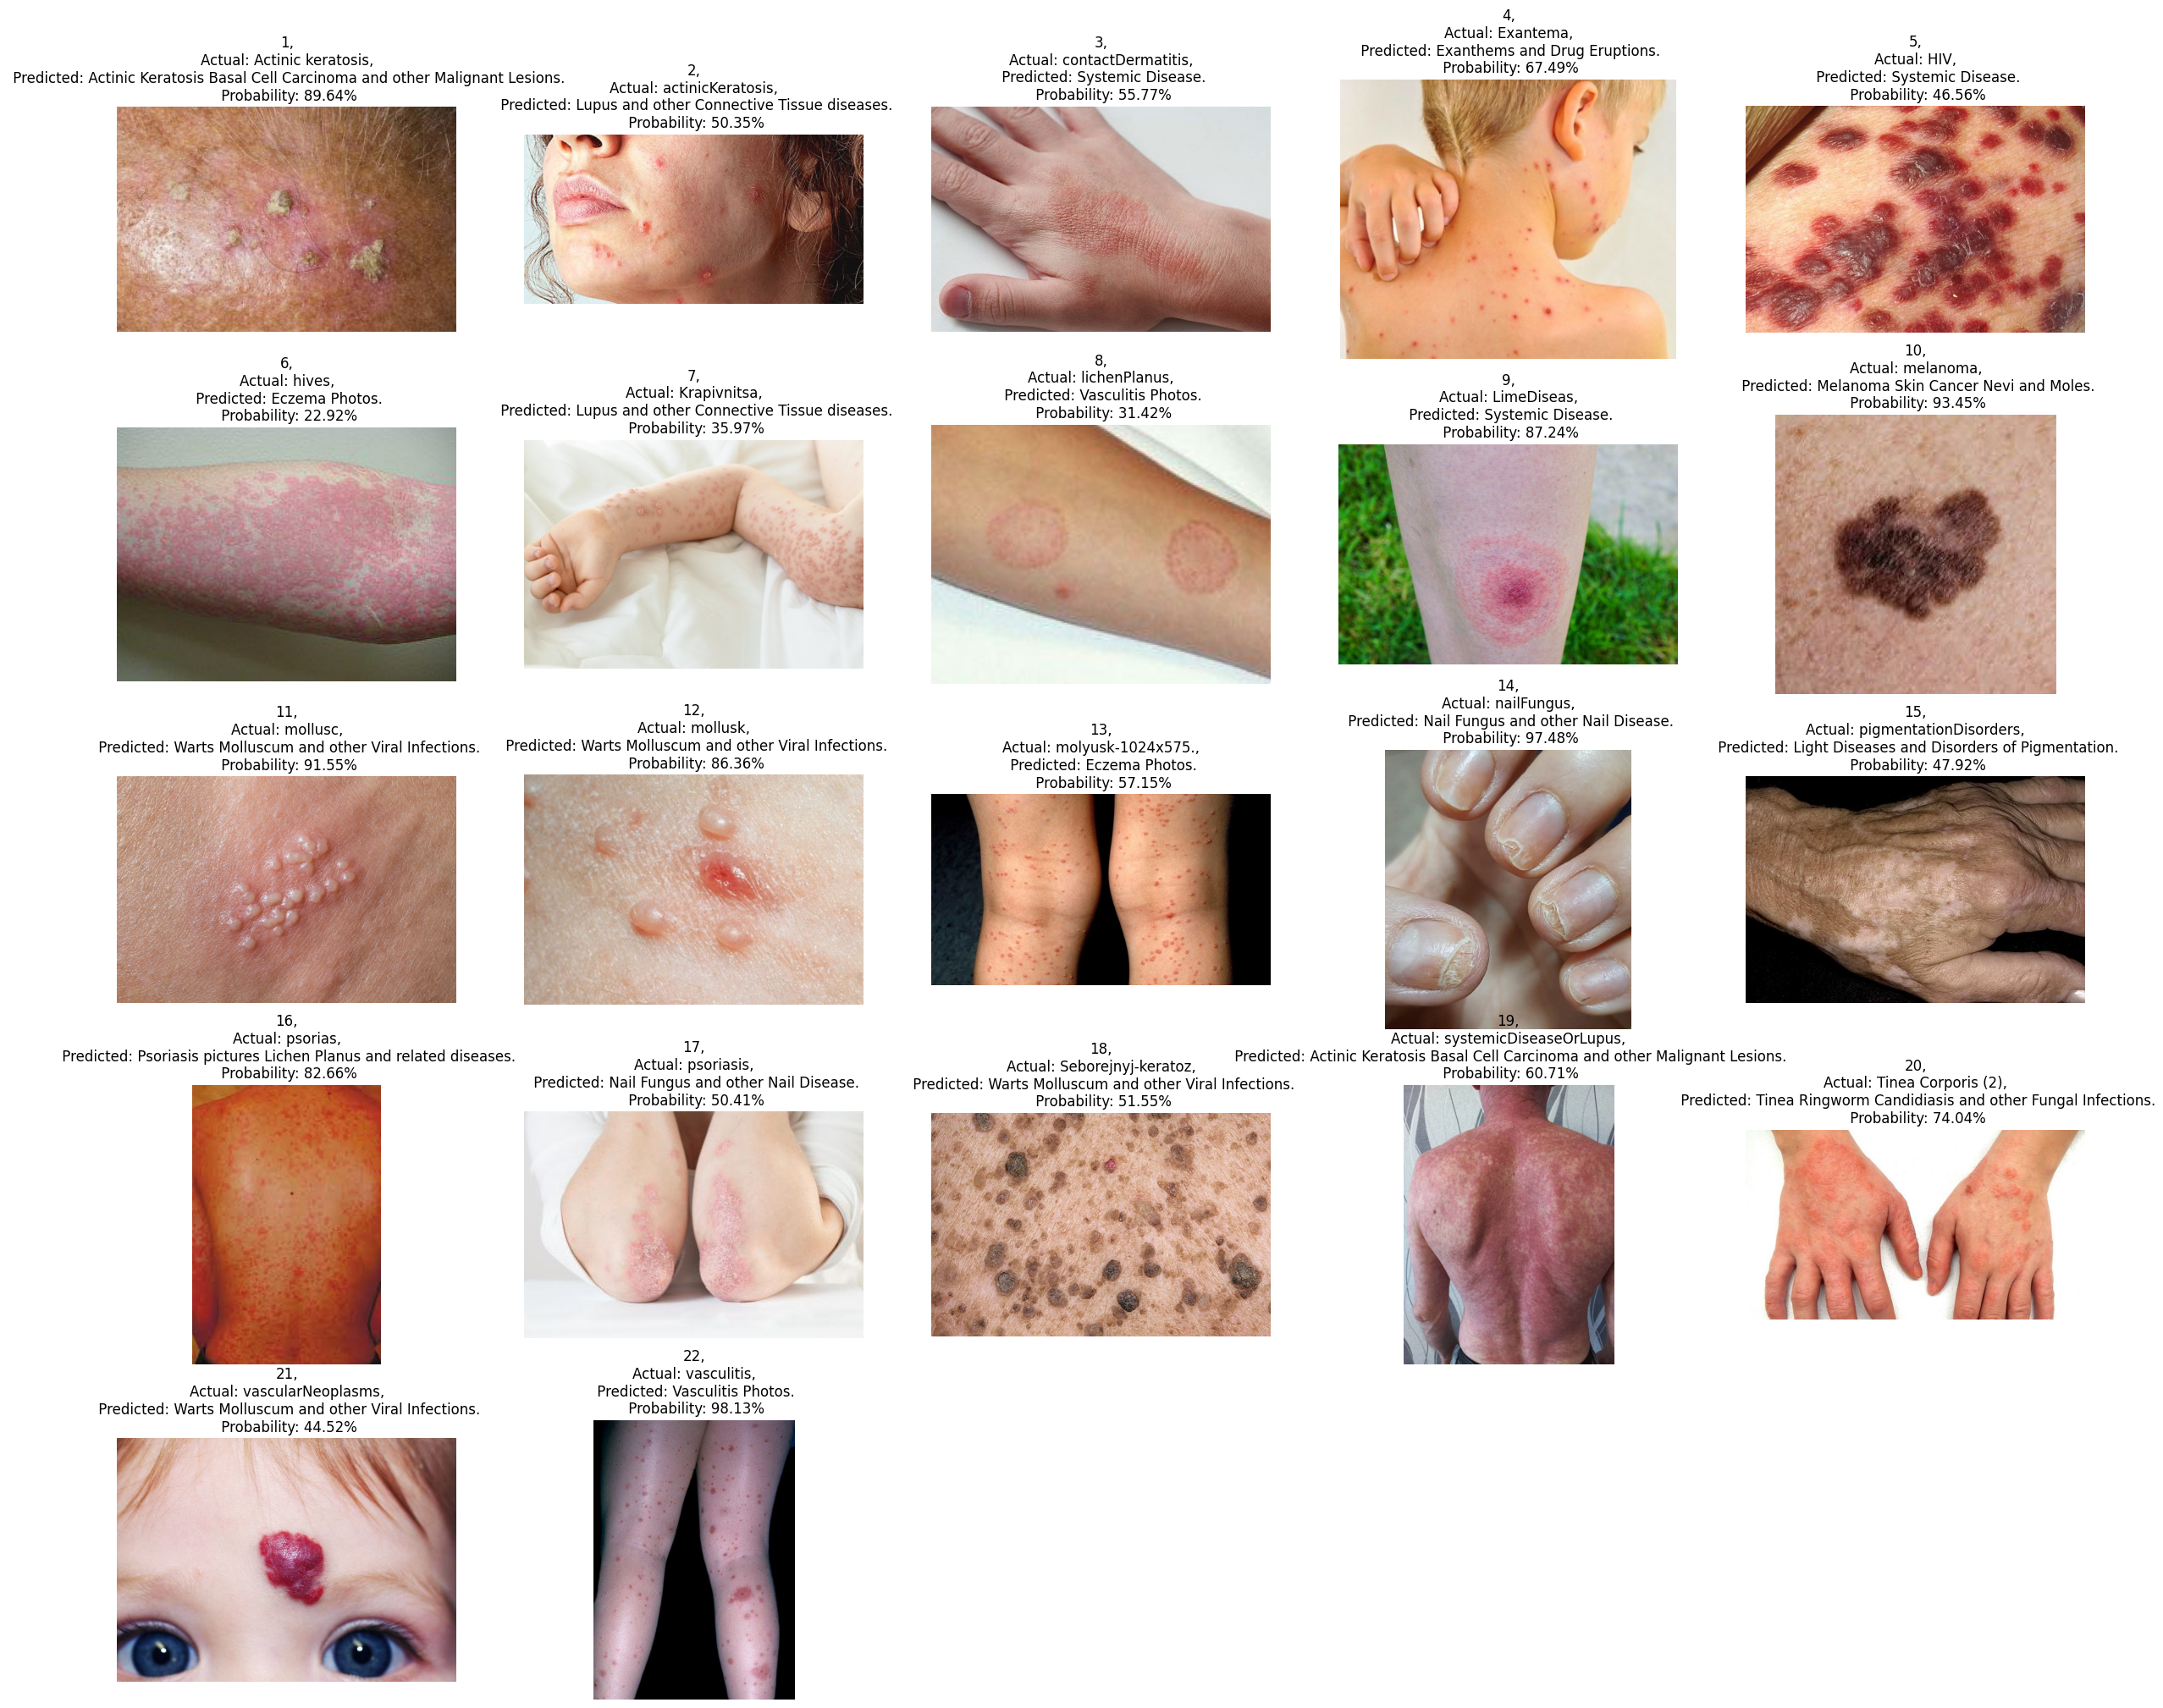

In [214]:
from PIL import Image

plt.figure(figsize=(30, 30))
images_path = 'D:/univ/diplom/diplom/archive/control'
paths, images, names = parse_folder(images_path)

for i in range(len(images)):
    s = images[i]
    img = Image.open(paths[i])
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(img)

    cv2.imread(str(img))

    img_array = load_img(str(paths[i]))

    predictions = model.predict(img_array)
    actual_class = names[i][0:-4]
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
        
    plt.title(f"{i+1},\nActual: {actual_class},\n Predicted: {predicted_class}.\n Probability: {confidence}%")
        
    plt.axis("off")

In [3]:
model = tf.keras.models.load_model('D:/univ/diplom/diplom/res-with-percents-v4')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 2048)              9439232   
                                                                 
 dense_129 (Dense)           (None, 1024)              2098176   
                                                                 
 dense_130 (Dense)           (None, 512)               524800    
                                                                 
 dense_131 (Dense)           (None, 256)               131328    
                                                                 
 dense_132 (Dense)           (None, 128)               32896     
                                                                 
 dense_133 (Dense)           (None, 23)                2967      
                                                                 
Total params: 12,229,399
Trainable params: 12,229,399